Inverse Problem

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import json
import math
from hole_data import hole_data, post_hole_data
from dataclasses import dataclass
from sklearn.cluster import DBSCAN
from scipy.optimize import least_squares
from scipy.optimize import minimize

Simulation

In [4]:
# Function to calculate the endpoints of a mirror given center, length, and angle
def calculate_mirror_endpoints(center, length, angle):
    half_length = length / 2
    angle_rad = np.radians(angle)
    start = (
        center[0] - half_length * np.cos(angle_rad),
        center[1] - half_length * np.sin(angle_rad),
    )
    end = (
        center[0] + half_length * np.cos(angle_rad),
        center[1] + half_length * np.sin(angle_rad),
    )
    return start, end

# Function to find the intersection of two lines
def find_intersection(p1, p2, p3, p4, eps=1e-9):
    # Laser direction (t parameter)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    r = np.array([x2 - x1, y2 - y1], dtype=float)  # laser direction
    s = np.array([x4 - x3, y4 - y3], dtype=float)  # mirror direction

    rxs = r[0]*s[1] - r[1]*s[0]
    if abs(rxs) < eps:
        return None  # parallel / nearly parallel

    qp = np.array([x3 - x1, y3 - y1], dtype=float)

    # Solve p1 + t r = p3 + u s
    t = (qp[0]*s[1] - qp[1]*s[0]) / rxs
    u = (qp[0]*r[1] - qp[1]*r[0]) / rxs

    # Mirror segment constraint: u in [0, 1]
    # Laser ray constraint: t >= 0 (in front of start)
    if t >= -eps and -eps <= u <= 1 + eps:
        return (x1 + t*r[0], y1 + t*r[1])

    return None

# Function to calculate the reflection of a laser beam
def reflect_laser(laser_start, laser_angle, mirrors, last_mirror):
    laser_angle_rad = np.radians(laser_angle)
    laser_far_end = (
        laser_start[0] + np.cos(laser_angle_rad) * 1000,
        laser_start[1] + np.sin(laser_angle_rad) * 1000,
    )
    
    closest_intersection = None
    closest_mirror = None
    min_distance = float('inf')

    # Find the closest intersection, ignoring the last mirror hit
    for mirror in mirrors:
        if mirror == last_mirror:
            continue
        intersection = find_intersection(laser_start, laser_far_end, mirror[0], mirror[1])
        if intersection is not None:
            distance = np.linalg.norm(np.array(intersection) - np.array(laser_start))
            if distance < min_distance:
                min_distance = distance
                closest_intersection = intersection
                closest_mirror = mirror

    if closest_intersection is None:
        return None, None, None  # No reflection
    
    # Reflection calculation
    mirror_start, mirror_end = closest_mirror
    mirror_vector = np.array([mirror_end[0] - mirror_start[0], mirror_end[1] - mirror_start[1]])
    mirror_length = np.linalg.norm(mirror_vector)
    mirror_unit_vector = mirror_vector / mirror_length
    normal_vector = np.array([-mirror_unit_vector[1], mirror_unit_vector[0]])
    incident_vector = np.array([closest_intersection[0] - laser_start[0], closest_intersection[1] - laser_start[1]])
    reflection_vector = (
        incident_vector - 2 * np.dot(incident_vector, normal_vector) * normal_vector
    )
    reflected_end = (
        closest_intersection[0] + reflection_vector[0],
        closest_intersection[1] + reflection_vector[1],
    )
    return closest_intersection, reflected_end, closest_mirror

In [5]:
# Function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Simulate laser reflections with length calculation
def simulate_laser_with_length(laser_start, laser_angle, mirrors, max_reflections=36):
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    laser_path = [laser_start]  # Track laser path

    for _ in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections; add final endpoint and break
            laser_far_end = (
                current_position[0] + np.cos(np.radians(current_angle)) * 1000,
                current_position[1] + np.sin(np.radians(current_angle)) * 1000,
            )
            laser_path.append(laser_far_end)
            break

        # Update the path and continue simulation
        laser_path.append(intersection)
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    # Calculate total laser length
    total_length = sum(calculate_distance(laser_path[i], laser_path[i + 1]) for i in range(len(laser_path) - 2))
    return laser_path, total_length

def extend_line(p1, p2):
    # Calculate the length of the line
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    # Extend the line in both directions
    new_p1 = (p1[0] - 0.73*dx, p1[1] - 0.73*dy)  # Extend p1 backwards
    new_p2 = (p2[0] + 0.73*dx, p2[1] + 0.73*dy)  # Extend p2 forwards
    return new_p1, new_p2

def create_orthogonal_line_at_endpoint(endpoint, other_endpoint, length=44):
    """Create an orthogonal line of the specified length at a given endpoint."""
    # Calculate the direction vector of the original line
    dx = other_endpoint[0] - endpoint[0]
    dy = other_endpoint[1] - endpoint[1]
    
    # Get orthogonal direction
    orthogonal_dx = -dy
    orthogonal_dy = dx
    magnitude = np.sqrt(orthogonal_dx**2 + orthogonal_dy**2)
    unit_dx = orthogonal_dx / magnitude
    unit_dy = orthogonal_dy / magnitude

    # Compute the two endpoints of the orthogonal line
    ortho_p1 = (endpoint[0] + unit_dx * length, endpoint[1] + unit_dy * length)
    ortho_p2 = (endpoint[0] - unit_dx * length, endpoint[1] - unit_dy * length)
    return ortho_p1, ortho_p2

def select_furthest_orthogonal_line(endpoint, ortho_p1, ortho_p2, reference_x=100):
    """Select the orthogonal line endpoint furthest away from reference_x."""
    # Calculate distances from reference_x for each orthogonal endpoint
    dist_ortho_p1 = abs(ortho_p1[0] - reference_x)
    dist_ortho_p2 = abs(ortho_p2[0] - reference_x)
    
    # Return the endpoint further from reference_x
    if dist_ortho_p1 > dist_ortho_p2:
        return (endpoint, ortho_p1)
    else:
        return (endpoint, ortho_p2)

def process_mirrors(mirrors):
    doubled_lines = []
    orthogonal_lines = []
    
    for p1, p2 in mirrors:
        # Double the length of the original line
        extended_p1, extended_p2 = extend_line(p1, p2)
        doubled_lines.append((extended_p1, extended_p2))

        # Create orthogonal lines at the endpoints of the doubled line
        ortho_p1_a, ortho_p1_b = create_orthogonal_line_at_endpoint(extended_p1, extended_p2)
        ortho_p2_a, ortho_p2_b = create_orthogonal_line_at_endpoint(extended_p2, extended_p1)
        
        # Select only the orthogonal line furthest from x=100
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p1, ortho_p1_a, ortho_p1_b))
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p2, ortho_p2_a, ortho_p2_b))

    return doubled_lines, orthogonal_lines

In [6]:
# The diameter of usable mirror. Given 1 inch mirror: 25.4mm. Clear aperture from spec sheet: 22.9mm.
# 3mm diameter beam. 22.9 - (3/2) = 21.4 mm
mirror_lengths = [21.4, 21.4, 21.4, 21.4]

# Set up the laser
laser_start = (0, 100)
laser_angle = 0  # Initial laser angle in degrees

In [7]:
#Quad Cell Locations
qc_1 = np.array([-100, 137])
qc_2 = np.array([-300, 190])

In [8]:
def execution(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    # Initialize plot
    plt.figure(figsize=(12, 10))
    plt.scatter(*laser_start, color='red', label="Laser Source", linewidth=1)

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Draw the mirrors
    for i, mirror in enumerate(mirrors):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], color = 'black', linewidth=3)

    #Draw piezo mirror mounts outline for fitting purposes
    for i, mirror in enumerate(doubled_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    for i, mirror in enumerate(orthogonal_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    reflection_count = 0

    for i in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections
            plt.plot(
                [current_position[0], current_position[0] + np.cos(np.radians(current_angle)) * 1000],
                [current_position[1], current_position[1] + np.sin(np.radians(current_angle)) * 1000],
                'g--'
            )
            break

        # Draw the laser and reflection
        plt.plot([current_position[0], intersection[0]], [current_position[1], intersection[1]], 'r-', linewidth =1)
        #plt.plot([intersection[0], reflected_end[0]], [intersection[1], reflected_end[1]], 'g-')
        #plt.scatter(*intersection, color='orange', label=f"Intersection {i+1}")
    
        # Update for next reflection
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror
        reflection_count += 1

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    #Identify if the exiting beam gets clipped with M4
    a = np.array([a[0], a[1]])
    b = np.array([b[0], b[1]])
    m = np.array([m4cx, m4cy])
    v = b - a
    d = np.array([np.cos(np.deg2rad(m4a)), np.sin(np.deg2rad(m4a))])
    A = np.column_stack((v, -d))
    t, s = np.linalg.solve(A, m - a)
    if 0 <= t <= 1:
        p = a + t * v
        dist = np.linalg.norm(p - m)
    else:
        # Beam does not pass near M4 — no clipping possible
        print("Beam does not intersect M4 region")
        dist = np.inf

    if dist >= 14.3: # Mirror diameter = 25.4mm. laser beam diameter = 3mm. (25.4/2) + (3/2) + 0.1(<- additional edge of mirror error)
        print("NOT CLIPPED, room to spare: ", dist-14.3, "mm")
    else:
        print("CLIPPED, ", dist-14.3, 'mm too much')
        
    print("Laser Path:", laser_path)
    print("Total Laser Length:", total_length+distance, "mm")
    print("Total Number of Reflection (N_R) = ", reflection_count)

    # Finalize plot
    plt.xlim(-310, 250)
    plt.ylim(-10, 210)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Laser Reflection with Multiple Mirrors")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.grid(True, linewidth=0.3)
    plt.plot([qc_1[0],qc_1[0]],[qc_1[1] - 2, qc_1[1] + 2], linewidth=4, label='QC1') # Quadcell Detector 1
    plt.plot([qc_2[0],qc_2[0]],[qc_2[1] - 2, qc_2[1] + 2], linewidth=4, label='QC2') # Quadcell Detector 2
    plt.legend(prop={'size': 8})
    plt.show()

In [9]:
def execution_reflec(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    """
    Simulates the laser path and returns a list of coordinates for each reflection point.
    Output: [(x0, y0), (x1, y1), ... (xn, yn)]
    """
    # 1. Setup Mirror Endpoints
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a]
    
    mirrors = []
    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    # 2. Simulation Loop
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    
    # Initialize path with the starting point
    path = [current_position]

    for _ in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(
            current_position, current_angle, mirrors, last_mirror
        )
        
        if intersection is None:
            # Optional: Add one final point far in the distance to show the exit beam
            exit_dist = 1000
            final_x = current_position[0] + np.cos(np.radians(current_angle)) * exit_dist
            final_y = current_position[1] + np.sin(np.radians(current_angle)) * exit_dist
            path.append((final_x, final_y))
            break

        # Append the reflection point
        path.append(intersection)
        
        # Update for next reflection
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    return path

In [10]:
def execution_identifier(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    last_two = laser_path[-2:]
    exit_slope = (last_two[1][1]-last_two[0][1])/(last_two[1][0]-last_two[0][0])
    y_int=last_two[1][1]-exit_slope*last_two[1][0]
    y100=exit_slope*-100+y_int
    y200=exit_slope*-200+y_int
    y300=exit_slope*-300+y_int
    y525=exit_slope*-525+y_int
    print(f"Exit angle: {exit_slope}")
    print(f"Total length: {total_length + distance}")
    print(f"y100: {y100-137}")
    print(f"y200: {y200-163.5}")
    print(f"y300: {y300-190}")
    print(f"y525: {y525-249.63}")

    return exit_slope, total_length + distance, y100-137, y300-190

ArUcos

In [12]:
intrinsics_path = r"C:\Users\alber\Documents\hardware_project\intrinsics_fisheye.json"

with open(intrinsics_path, "r") as f:
    intr = json.load(f)

K = np.array(intr["K"], dtype=np.float64)
D = np.array(intr["D"], dtype=np.float64)  # shape (N,1) or (1,N) is fine
img_w = intr["image_width"]
img_h = intr["image_height"]

In [13]:
obj_xyz = []
img_uv  = []

# Table holes: Z = 0
for X, Y, u, v in hole_data:
    obj_xyz.append([X, Y, 0.0])
    img_uv.append([u, v])

# Post tops: Z = H
for X, Y, u, v, H in post_hole_data:
    obj_xyz.append([X, Y, H])
    img_uv.append([u, v])

obj_xyz = np.array(obj_xyz, dtype=np.float64)
img_uv  = np.array(img_uv,  dtype=np.float64)

print("Using", obj_xyz.shape[0], "points for pose estimation.")

success, rvec_cw, tvec_cw = cv.solvePnP(
    objectPoints=obj_xyz,
    imagePoints=img_uv,
    cameraMatrix=K,
    distCoeffs=D,
    flags=cv.SOLVEPNP_ITERATIVE
)

if not success:
    raise RuntimeError("solvePnP failed")

R_cw, _ = cv.Rodrigues(rvec_cw)  # world -> camera
t_cw = tvec_cw                   # 3x1

R_wc = R_cw.T                    # camera -> world
t_wc = -R_wc @ t_cw              # camera center in world coords

Using 160 points for pose estimation.


Transition Functions

In [15]:
def pixel_to_world_on_plane(u, v, H_in=0.0, override_cam_height=None):
    pts = np.array([[[u, v]]], dtype=np.float64)
    rays_norm = cv.undistortPoints(pts, K, D)  # pinhole model
    x, y = rays_norm[0,0]
    d_cam = np.array([x, y, 1.0], dtype=np.float64)

    d_w = R_wc @ d_cam

    C_w = t_wc.reshape(3).copy()
    if override_cam_height is not None:
        C_w[2] = float(override_cam_height)

    lam = (H_in - C_w[2]) / d_w[2]
    Pw = C_w + lam * d_w
    return float(Pw[0]), float(Pw[1])

In [16]:
def world_to_pixel(X, Y, Z):
    obj = np.array([[[X, Y, Z]]], dtype=np.float64)  # (1,1,3)
    img_proj, _ = cv.projectPoints(obj, rvec_cw, tvec_cw, K, D)
    u, v = img_proj.reshape(2)
    return float(u), float(v)

Reading ArUcos

[detect] Found 13 candidate markers using DICT_4X4_100
[filter] Kept 12 markers from allowed IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


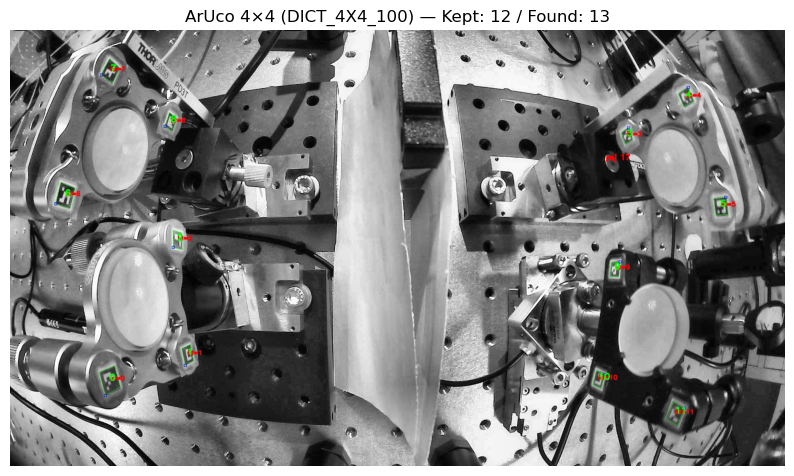

[out] Ready: detected list with 12 kept markers (ids, corners, centers).
  id=0, center=[247.35807037 867.06169128], TL=[236.32606506 905.1953125 ]
  id=10, center=[1458.57550049  865.20207214], TL=[1473.30200195  852.80828857]
  id=6, center=[136.88309288 410.19425201], TL=[113. 430.]
  id=11, center=[1648.5   949.75], TL=[1671.  936.]
  id=7, center=[249.07152176 101.28985786], TL=[226. 111.]


In [18]:
# Config
img_path = "N2L.jpg"   # set your image path
dict_name = "DICT_4X4_100"                 # choose your 4x4 family: DICT_4X4_50/100/250/1000
allowed_ids = {0,1,2,3,4,5,6,7,8,9,10,11}   # <<< replace with YOUR printed IDs
use_CLAHE = True                           # True: local equalization; False: global hist eq
resize_factor = 1.0                         # e.g., 1.5 if markers are tiny/pixelated

# Load + grayscale + enhance
img_bgr = cv.imread(img_path)
assert img_bgr is not None, f"Could not read image at {img_path}"
gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

# Optional upsample for tiny markers
if resize_factor != 1.0:
    gray = cv.resize(gray, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)
    img_bgr = cv.resize(img_bgr, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)

# Contrast enhancement
if use_CLAHE:
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)
else:
    gray_eq = cv.equalizeHist(gray)

# ArUco detection (4x4 dict)
aruco_dict = cv.aruco.getPredefinedDictionary(getattr(cv.aruco, dict_name))

# Detector parameters (tuned for small/low-contrast markers)
try:
    params = cv.aruco.DetectorParameters()
except AttributeError:
    params = cv.aruco.DetectorParameters_create()

params.adaptiveThreshWinSizeMin = 3
params.adaptiveThreshWinSizeMax = 45
params.adaptiveThreshWinSizeStep = 3
params.adaptiveThreshConstant   = 7
params.minMarkerPerimeterRate   = 0.01
params.maxMarkerPerimeterRate   = 5.0
params.minCornerDistanceRate    = 0.01
params.cornerRefinementMethod   = cv.aruco.CORNER_REFINE_SUBPIX

# Detect (handle both new/old OpenCV APIs)
try:
    detector = cv.aruco.ArucoDetector(aruco_dict, params)
    corners, ids, rejected = detector.detectMarkers(gray_eq)
except AttributeError:
    corners, ids, rejected = cv.aruco.detectMarkers(gray_eq, aruco_dict, parameters=params)

total_found = 0 if ids is None else len(ids)
print(f"[detect] Found {total_found} candidate markers using {dict_name}")

# Filter to allowed_ids
filtered_corners, filtered_ids = [], []
rejected_by_id = []  # for visualization/debug

if ids is not None:
    for c, i in zip(corners, ids.flatten()):
        if int(i) in allowed_ids:
            filtered_corners.append(c)
            filtered_ids.append([int(i)])   # keep as nested list for OpenCV
        else:
            rejected_by_id.append((c, int(i)))

if len(filtered_ids) == 0:
    print("[filter] No allowed markers detected!")
else:
    print(f"[filter] Kept {len(filtered_ids)} markers from allowed IDs: {sorted(allowed_ids)}")

# Convert to numpy for downstream OpenCV calls
ids_kept = np.array(filtered_ids, dtype=np.int32) if filtered_ids else None
corners_kept = filtered_corners

# Build a nice visualization
#   - green boxes = kept (allowed)
#   - red boxes   = rejected-by-ID (optional)
vis = cv.cvtColor(gray_eq, cv.COLOR_GRAY2RGB)

# Draw kept markers in green
if ids_kept is not None and len(ids_kept) > 0:
    cv.aruco.drawDetectedMarkers(vis, corners_kept, ids_kept)
    for c, i in zip(corners_kept, ids_kept.flatten()):
        center = c.reshape(-1,2).mean(axis=0).astype(int)
        cv.putText(vis, f"{int(i)}", tuple(center), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv.LINE_AA)

# Optionally draw rejected-by-ID in red (helps you see the false positive)
for c, i in rejected_by_id:
    pts = c.reshape(4,2).astype(int)
    cv.polylines(vis, [pts], True, (255,0,0), 2, cv.LINE_AA)
    center = pts.mean(axis=0).astype(int)
    cv.putText(vis, f"rej {int(i)}", tuple(center), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2, cv.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(vis)
plt.title(f"ArUco 4×4 ({dict_name}) — Kept: {0 if ids_kept is None else len(ids_kept)} / Found: {total_found}")
plt.axis('off')
plt.show()

# Collect outputs for downstream use
detected = []
if ids_kept is not None:
    for c, i in zip(corners_kept, ids_kept.flatten()):
        pts = c.reshape(4,2).astype(float)    # TL, TR, BR, BL
        center = pts.mean(axis=0)
        # If you upsampled (resize_factor != 1), pts/center are already in the resized pixel space.
        # If you want original-image coordinates instead, divide by resize_factor here.
        detected.append({"id": int(i), "corners": pts, "center": center})

print(f"[out] Ready: detected list with {len(detected)} kept markers (ids, corners, centers).")
# Example peek:
for d in detected[:5]:
    print(f"  id={d['id']}, center={d['center']}, TL={d['corners'][0]}")

In [19]:
def camera_arucos(img_path):
    # --- Config ---
    dict_name = "DICT_4X4_100"
    allowed_ids = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
    resize_factor = 1.0  # Set this to 1.0 to match the original's actual run
    
    img_bgr = cv.imread(img_path)
    if img_bgr is None: return []
    
    gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

    if resize_factor != 1.0:
        gray = cv.resize(gray, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray)

    aruco_dict = cv.aruco.getPredefinedDictionary(getattr(cv.aruco, dict_name))
    try:
        params = cv.aruco.DetectorParameters()
    except AttributeError:
        params = cv.aruco.DetectorParameters_create()

    # --- THE MISSING CRITICAL PARAMS ---
    params.adaptiveThreshWinSizeMin = 3
    params.adaptiveThreshWinSizeMax = 45
    params.adaptiveThreshWinSizeStep = 3  # <--- Crucial for detection density
    params.minMarkerPerimeterRate = 0.01   # <--- Crucial for small markers
    params.cornerRefinementMethod = cv.aruco.CORNER_REFINE_SUBPIX

    try:
        detector = cv.aruco.ArucoDetector(aruco_dict, params)
        corners, ids, _ = detector.detectMarkers(gray_eq)
    except AttributeError:
        corners, ids, _ = cv.aruco.detectMarkers(gray_eq, aruco_dict, parameters=params)

    # Temporary list to hold (id, (x, y)) tuples
    found_markers = []
    
    if ids is not None:
        for c, i in zip(corners, ids.flatten()):
            marker_id = int(i)
            if marker_id in allowed_ids:
                pts = c.reshape(4, 2)
                center = pts.mean(axis=0)
                
                # Scale back to original resolution
                if resize_factor != 1.0:
                    center = center / resize_factor
                
                found_markers.append((marker_id, tuple(center)))

    # --- Sorting Logic ---
    # Sort by the first element of the tuple (the ID)
    found_markers.sort(key=lambda x: x[0])

    # Extract only the coordinates from the sorted list
    sorted_centers = [coords for marker_id, coords in found_markers]

    return sorted_centers

In [20]:
coords = camera_arucos(img_path = "N2L.jpg")
coords

[(247.35806, 867.06165),
 (439.8616, 804.0738),
 (414.68738, 520.0469),
 (1528.2871, 262.4613),
 (1674.544, 166.72035),
 (1760.8492, 436.64786),
 (136.88309, 410.19424),
 (249.07152, 101.289856),
 (398.24997, 227.70412),
 (1498.6907, 592.4035),
 (1458.5754, 865.2021),
 (1648.5, 949.75)]

In [21]:
heights = {0: 4.722167,
    1: 3.4291,
    2: 3.4210290000000003,
    3: 3.471474,
    4: 4.776629,
    5: 4.76645,
    6: 4.774986,
    7: 4.780836,
    8: 3.47397,
    9: 3.32363,
    10: 3.280905,
    11: 4.705506000000001}

In [22]:
shifts_LR = {0: 0.017658,
    1: 0.01895,
    2: -0.01143,
    3: -0.00125,
    4: -0.004104,
    5: 0.01212,
    6: 0.03053,
    7: 0.01846,
    8: 0.018335,
    9: -0.01785,
    10: -0.013066,
    11: 0.039195
}

In [23]:
shifts_UD = {0: -0.000583,
    1: 0.01630,
    2: 0.009529,
    3: -0.005546,
    4: -0.018201,
    5: -0.03784,
    6: 0.000196,
    7: 0.001556,
    8: 0.00097,
    9: -0.02202,
    10: -0.021515,
    11: -0.012064
}

In [24]:
def get_center_for_id(detected, tag_id):
    for d in detected:
        if d["id"] == tag_id:
            return float(d["center"][0]), float(d["center"][1])  # (u,v)
    raise ValueError(f"Marker ID {tag_id} not found")

def world_point_from_id(tag_id, detected):
    u, v = get_center_for_id(detected, tag_id)
    H = heights[tag_id]
    X, Y = pixel_to_world_on_plane(u, v, H_in=H, override_cam_height=None)
    return np.array([X, Y, H], dtype=np.float64)

def mirror_center_from_ids(id0, id1, id2):

    P0 = world_point_from_id(id0, detected)
    P1 = world_point_from_id(id1, detected)
    P2 = world_point_from_id(id2, detected)

    M = 0.5 * (P0 + P2)

    return M

In [25]:
def offset_point_negative_x(id0, id1, id2, neg=True, offset=0.045):
    P0 = world_point_from_id(id0, detected)
    P1 = world_point_from_id(id1, detected)
    P2 = world_point_from_id(id2, detected)
    M = 0.5*(P0 + P2)

    # Plane normal (not normalized)
    n = np.cross(P1 - P0, P2 - P0)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-9:
        raise ValueError("Points are collinear — no plane normal.")
    n_hat = n / n_norm   # unit normal

    # Choose the normal pointing in negative x direction
    if neg == True:
        if n_hat[0] < 0:
            n_use = n_hat
        else:
            n_use = -n_hat
    else:
        if n_hat[0] < 0:
            n_use = -n_hat
        else:
            n_use = n_hat

    P_offset = M + offset * n_use

    return P_offset

Laser Reflection Points

In [27]:
def pca_elongation(points_xy):
    """
    points_xy: (N,2) array of [x,y] in patch coords.
    returns (ratio, major_sigma, minor_sigma, angle_rad)
    """
    pts = points_xy.astype(float)
    pts -= pts.mean(axis=0, keepdims=True)

    C = np.cov(pts.T)
    vals, vecs = np.linalg.eigh(C)          # vals sorted ascending
    minor, major = np.sqrt(vals[0] + 1e-9), np.sqrt(vals[1] + 1e-9)
    ratio = major / minor
    angle = np.arctan2(vecs[1,1], vecs[0,1])  # direction of major axis
    return ratio, major, minor, angle


def split_cluster_k2(points_xy, n_iter=20):
    """
    Very small k-means for k=2 on points_xy.
    Returns centers (2,2) in patch coords.
    """
    pts = points_xy.astype(float)

    # init: pick two farthest points (good for peanuts)
    d2 = ((pts[:,None,:] - pts[None,:,:])**2).sum(axis=2)
    i, j = np.unravel_index(np.argmax(d2), d2.shape)
    c1, c2 = pts[i].copy(), pts[j].copy()

    for _ in range(n_iter):
        d1 = ((pts - c1)**2).sum(axis=1)
        d2 = ((pts - c2)**2).sum(axis=1)
        m1 = d1 <= d2
        m2 = ~m1
        if m1.sum() == 0 or m2.sum() == 0:
            break
        new_c1 = pts[m1].mean(axis=0)
        new_c2 = pts[m2].mean(axis=0)
        if np.allclose(new_c1, c1) and np.allclose(new_c2, c2):
            break
        c1, c2 = new_c1, new_c2

    return np.vstack([c1, c2])

In [28]:
def postprocess_split_peanuts(clusters, radius_split=18.0, elong_split=1.8, min_sep=6.0):
    """
    Splits clusters that look like two touching spots.
    Returns a new cluster list (some clusters replaced by two subclusters).
    """
    new_clusters = []
    next_label = 1000  # labels for split children

    for c in clusters:
        pts = np.array(c["points"], dtype=float)   # patch coords [x,y]
        if len(pts) < 20:
            new_clusters.append(c)
            continue

        ratio, major, minor, _ = pca_elongation(pts)

        # decide whether to split
        if (c["radius"] > radius_split) or (ratio > elong_split):
            centers2 = split_cluster_k2(pts)

            # reject split if the two centers are basically on top of each other
            if np.linalg.norm(centers2[0] - centers2[1]) < min_sep:
                new_clusters.append(c)
                continue

            # build two child clusters based on assignment
            d1 = ((pts - centers2[0])**2).sum(axis=1)
            d2 = ((pts - centers2[1])**2).sum(axis=1)
            m1 = d1 <= d2
            m2 = ~m1

            for m, center in [(m1, centers2[0]), (m2, centers2[1])]:
                sub_pts = pts[m]
                if len(sub_pts) < 5:
                    continue
                dist = np.linalg.norm(sub_pts - center, axis=1)
                radius = float(dist.max())
                x_min, y_min = np.min(sub_pts, axis=0)
                x_max, y_max = np.max(sub_pts, axis=0)

                new_clusters.append({
                    **c,
                    "label": int(next_label),
                    "center": center.tolist(),
                    "radius": radius,
                    "size": int(len(sub_pts)),
                    "points": sub_pts.tolist(),
                    "bbox": [float(x_min), float(x_max), float(y_min), float(y_max)],
                    "density": float(len(sub_pts) / (np.pi * radius**2)) if radius > 0 else 0.0,
                    "was_split": True,
                })
                next_label += 1
        else:
            new_clusters.append(c)

    # sort biggest first like you already do
    new_clusters.sort(key=lambda x: x["size"], reverse=True)
    return new_clusters

In [29]:
THRESHOLD = 180

def find_clusters_with_circles(patch, threshold=200, eps=5.0, min_samples=35, show=True, title=""):
    y_coords, x_coords = np.where(patch > threshold)

    if len(x_coords) == 0:
        if show:
            print("No points above threshold!")
        return []

    coordinates = np.column_stack([x_coords, y_coords])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(coordinates)

    unique_labels = set(labels)
    clusters = []

    for label in unique_labels:
        if label == -1:
            continue
        mask = labels == label
        cluster_points = coordinates[mask]

        center = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - center, axis=1)
        radius = np.max(distances)

        x_min, y_min = np.min(cluster_points, axis=0)
        x_max, y_max = np.max(cluster_points, axis=0)

        clusters.append({
            'label': int(label),
            'center': center.tolist(),      # [x, y] in PATCH coords
            'radius': float(radius),
            'size': int(len(cluster_points)),
            'points': cluster_points.tolist(),
            'bbox': [float(x_min), float(x_max), float(y_min), float(y_max)],
            'density': float(len(cluster_points) / (np.pi * radius**2)) if radius > 0 else 0.0
        })

    clusters.sort(key=lambda x: x['size'], reverse=True)

    clusters = postprocess_split_peanuts(clusters, radius_split=20.0, elong_split=2, min_sep=8.0)

    if show:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        axes[0].imshow(patch, cmap='gray')
        colors = plt.cm.tab10(np.linspace(0, 1, max(len(clusters), 1)))

        for i, cluster in enumerate(clusters):
            color = colors[i]
            center = cluster['center']
            radius = cluster['radius']

            circle = plt.Circle(center, radius, color=color, fill=False, linewidth=2, alpha=0.7)
            axes[0].add_patch(circle)
            axes[0].scatter(center[0], center[1], color=color, s=100, marker='x', linewidths=2)
            axes[0].text(center[0], center[1], f'C{i}', color='white', fontsize=12, fontweight='bold',
                         ha='center', va='center',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))

        axes[0].set_title(title or f'Found {len(clusters)} Cluster(s)')
        axes[0].axis('equal')

        axes[1].axis('off')
        if clusters:
            summary = "CLUSTER CENTERS:\n\n"
            for i, cluster in enumerate(clusters):
                summary += f"Cluster {i} (Label {cluster['label']}):\n"
                summary += f"  Center: ({cluster['center'][0]:.1f}, {cluster['center'][1]:.1f})\n"
                summary += f"  Radius: {cluster['radius']:.1f} px\n"
                summary += f"  Size: {cluster['size']} points\n"
                summary += f"  Density: {cluster['density']:.3f} pts/px²\n"
                summary += f"  BBox: [{cluster['bbox'][0]:.0f}-{cluster['bbox'][1]:.0f}, {cluster['bbox'][2]:.0f}-{cluster['bbox'][3]:.0f}]\n\n"
            axes[1].text(0.05, 0.95, summary, fontfamily='monospace',
                         verticalalignment='top', fontsize=10)

        plt.tight_layout()
        plt.show()

    return clusters


def clusters_in_roi(gray, roi, threshold=200, eps=5.0, min_samples=35, show=True):
    x1, y1, x2, y2 = roi
    patch = gray[y1:y2, x1:x2]

    clusters = find_clusters_with_circles(
        patch, threshold=threshold, eps=eps, min_samples=min_samples,
        show=show, title=f"ROI {roi} | threshold={threshold}, eps={eps}"
    )

    # Add full-image centers to each cluster dict
    for c in clusters:
        cx, cy = c["center"]  # patch coords
        c["center_full"] = [cx + x1, cy + y1]

    return clusters

In [30]:
img_bgr = cv.imread("N2D.jpg")

In [31]:
# Build grayscale once
gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

rois = {
    "M1": (200, 500, 400, 800),
    "M2": (1500, 200, 1750, 450),
    "M3": (100, 200, 350, 450),
    "M4": (1500, 600, 1700, 850),
}

In [32]:
def process_all_rois(gray_img, rois, threshold, eps=5.0, min_samples=35, show=False):
    results = {}
    for name, roi in rois.items():
        clusters = clusters_in_roi(
            gray_img, roi,
            threshold=threshold,
            eps=eps,
            min_samples=min_samples,
            show=show
        )
        results[name] = clusters
    return results

In [33]:
def reflec_pts_cam(gray_img, eps=5.0, min_samples=35, show=False):
    all_clusters = process_all_rois(
        gray_img,
        rois=rois,
        threshold=THRESHOLD,
        eps=eps,
        min_samples=min_samples,
        show=show
    )

    grouped = {k: [] for k in rois.keys()}

    # ---- Collect and group centers ----
    for clusters in all_clusters.values():
        for c in clusters:
            x, y = c["center_full"]
            for name, (x0, y0, x1, y1) in rois.items():
                if x0 <= x <= x1 and y0 <= y <= y1:
                    grouped[name].append([float(x), float(y)])
                    break

    # ---- Enforce expected reflection-count pattern ----
    # M1, M2, M3 have same count; M4 has one less
    base = max(len(grouped.get("M1", [])),
               len(grouped.get("M2", [])),
               len(grouped.get("M3", [])))

    expected = {
        "M1": base,
        "M2": base,
        "M3": base,
        "M4": max(0, base - 1),
    }

    for name, need in expected.items():
        pts = grouped[name]
        if len(pts) == 0:
            # If nothing detected, you can either leave empty or insert a dummy.
            # I'd leave empty so you notice it.
            continue

        # Duplicate last point until count matches expected
        while len(pts) < need:
            pts.append(pts[-1])

        # If too many, trim extras (keeps your residual length stable)
        if len(pts) > need:
            grouped[name] = pts[:need]

    return grouped

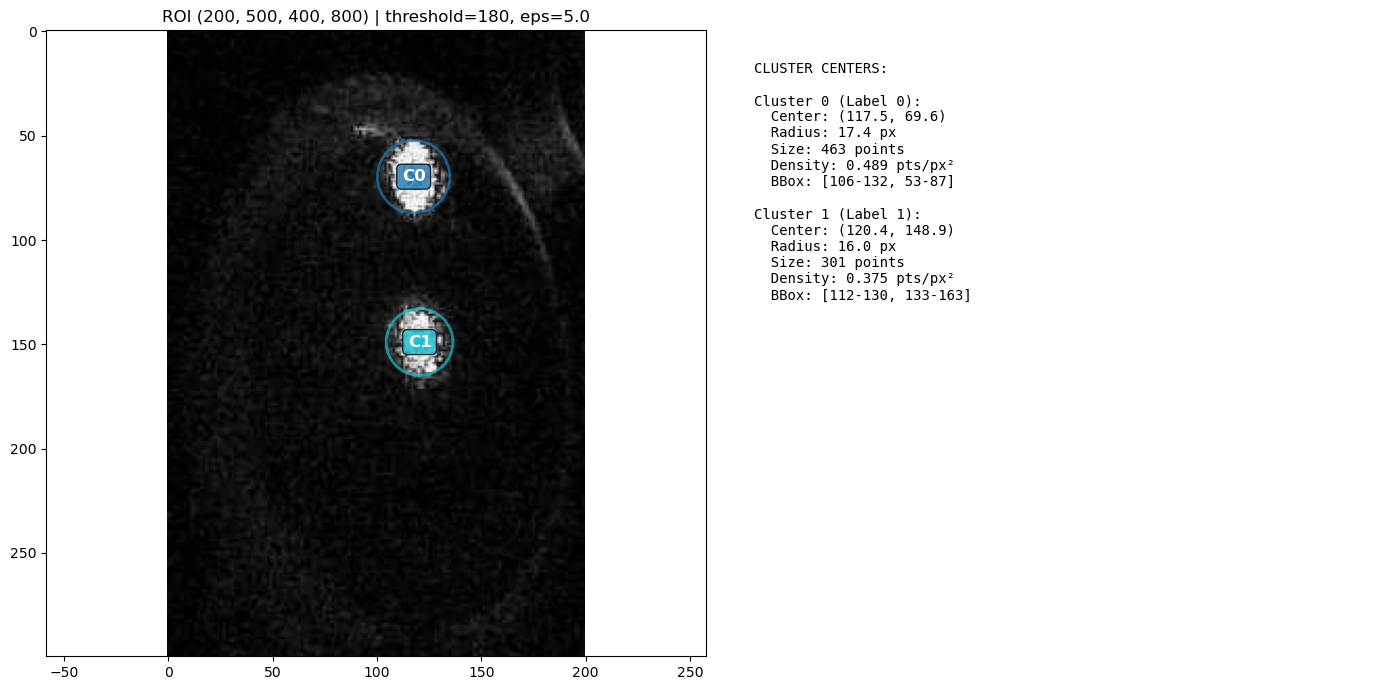

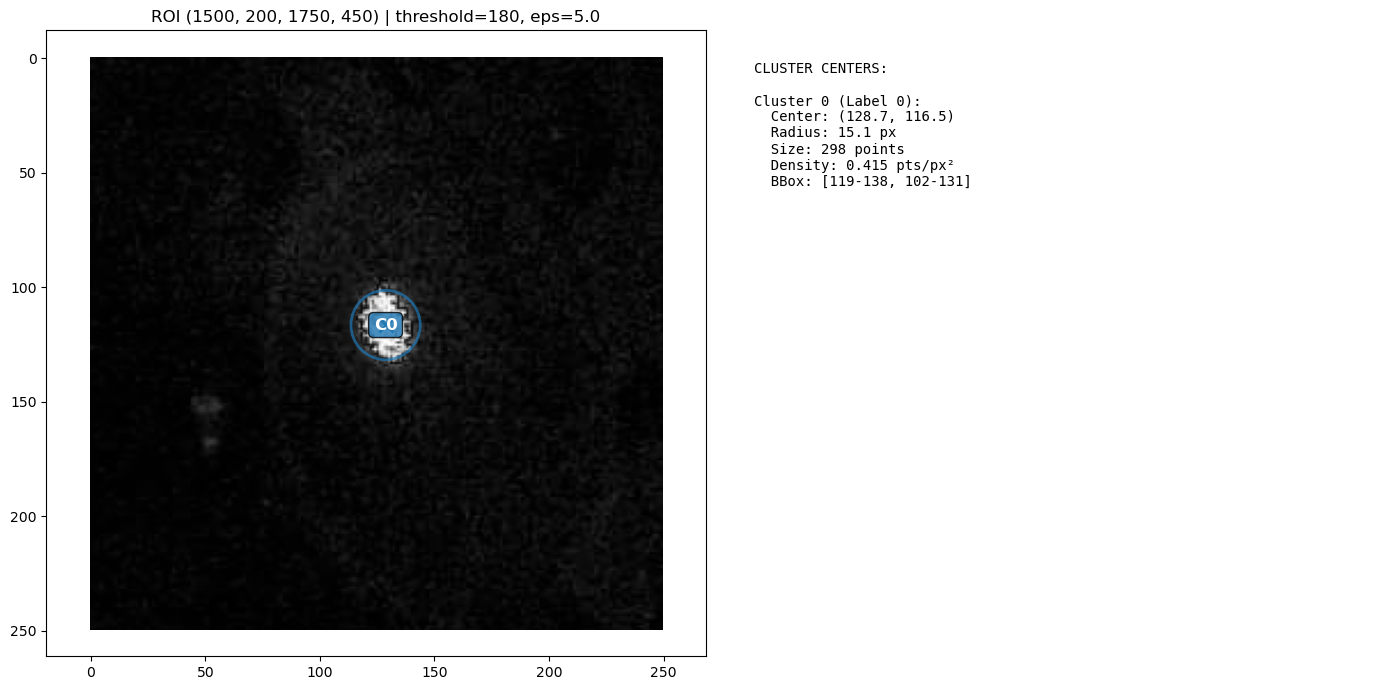

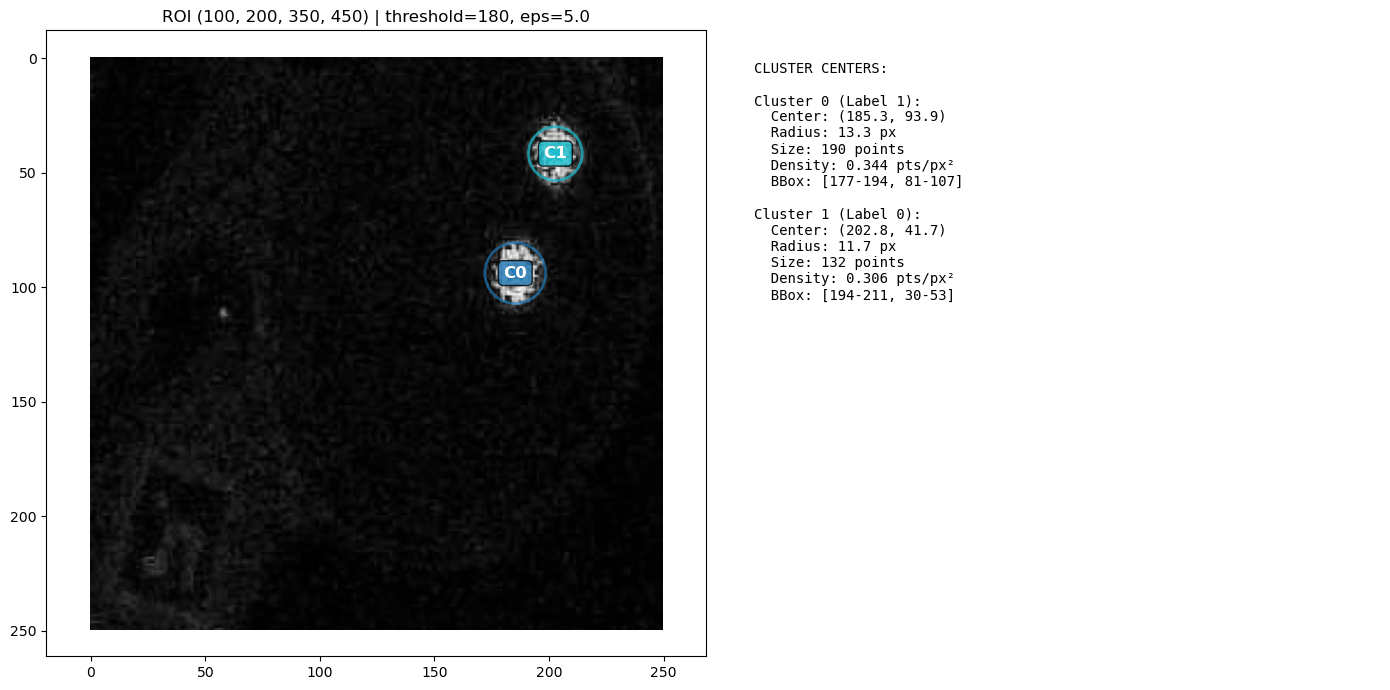

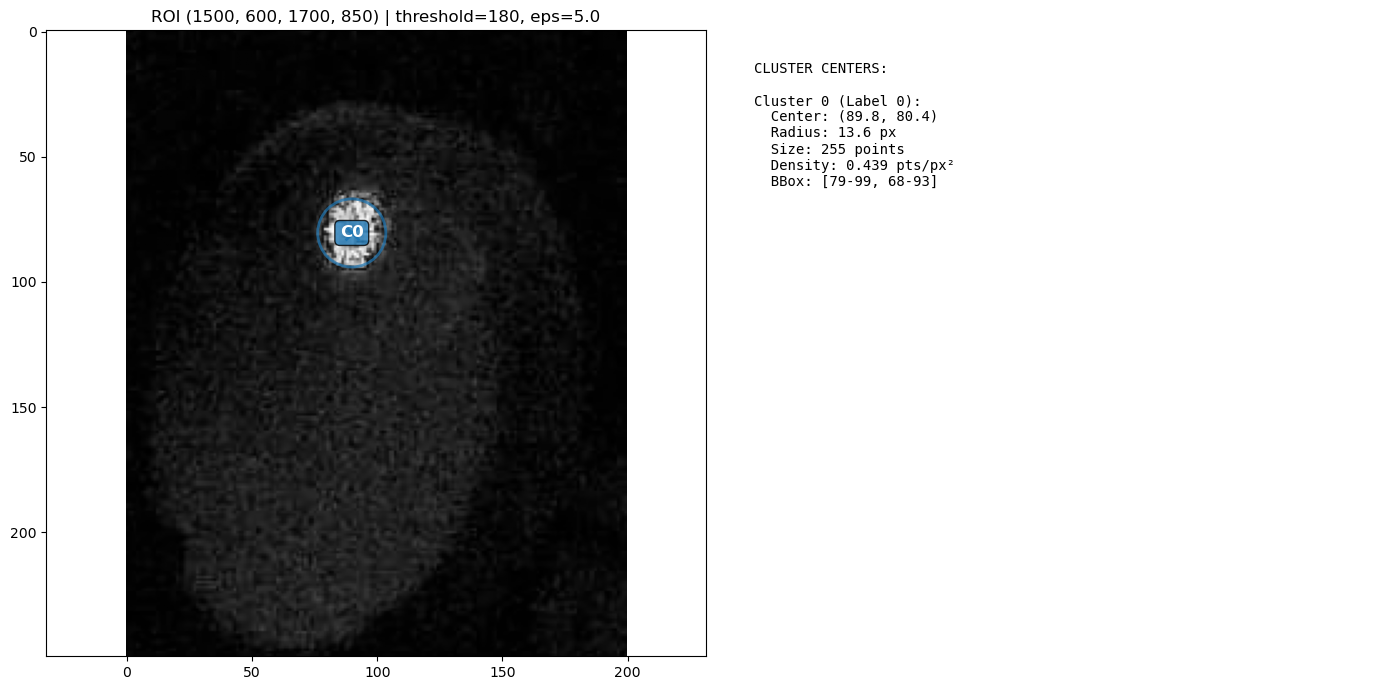

{'M1': [[317.53347732181425, 569.6414686825054],
  [320.37873754152827, 648.9036544850499]],
 'M2': [[1628.6744966442952, 316.5201342281879],
  [1628.6744966442952, 316.5201342281879]],
 'M3': [[285.2842105263158, 293.85263157894735],
  [302.78787878787875, 241.6969696969697]],
 'M4': [[1589.8196078431372, 680.4274509803921]]}

In [34]:
pts = reflec_pts_cam(gray, show=True)   # show=True if you want the ROI plots
pts

Inverse Problem

In [36]:
# Initialize mirror parameters:
M1 = [160, 109, 96.8312]
M2 = [20, 75, 96.9015]
M3 = [180, 71, 81.919]
M4 = [40, 117, 81.119]

NOT CLIPPED, room to spare:  2.3206922094099056 mm
Laser Path: [(0, 100), (161.07815591882658, 100.0), (21.092683891285475, 65.97252847346545), (179.34132220181854, 66.3608607973605), (38.52275910844779, 107.54602702559015), (160.5465957431594, 104.43724464844698), (21.00123554760816, 66.72805102237442), (178.87741465806064, 63.09350963023574), (-787.75309758636, 319.26816254907726)]
Total Laser Length: 1219.6913894315412 mm
Total Number of Reflection (N_R) =  7


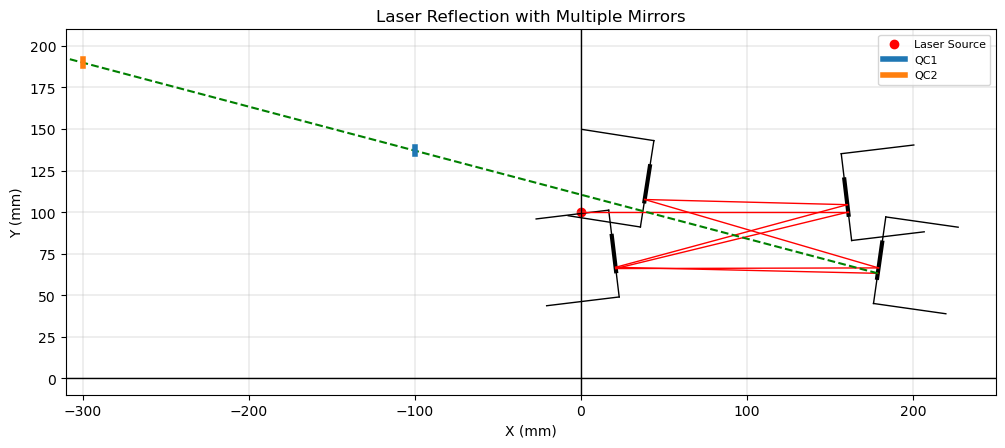

In [37]:
execution(M1[0], M1[1], #M1, (x,y)
          M2[0], M2[1], #M2, (x,y)
          M3[0], M3[1], #M3, (x,y)
          M4[0], M4[1], #M4, (x,y)
          M1[2], M2[2], M3[2], M4[2]) # Angle from positive x-axis (M1, M2, M3, M4)

In [38]:
execution_output = execution_identifier(M1[0], M1[1], #M1, (x,y)
          M2[0], M2[1], #M2, (x,y)
          M3[0], M3[1], #M3, (x,y)
          M4[0], M4[1], #M4, (x,y)
          M1[2], M2[2], M3[2], M4[2]) # Angle from positive x-axis (M1, M2, M3, M4)
execution_output

Exit angle: -0.26501817361840696
Total length: 1219.6913894315412
y100: 0.001092726338100647
y200: 0.0029100881787940125
y300: 0.0047274500195158
y525: 0.0038165141610591036


(-0.26501817361840696,
 1219.6913894315412,
 0.001092726338100647,
 0.0047274500195158)

In [39]:
execution_output[0]

-0.26501817361840696

In [40]:
def sim_to_pt(loc_x, loc_y):
    # Calibration constants from your original function
    calib_irl = [-2.65720102, -0.94574237]
    calib_sim = [-160, -109]

    # 1. Reverse the negation
    # Since: loc_x = -(diff_x + calib_sim[0])
    # Then:  -loc_x - calib_sim[0] = diff_x
    diff_x = -loc_x - calib_sim[0]
    diff_y = -loc_y - calib_sim[1]

    # 2. Reverse the scaling (25.4) and the IRL offset subtraction
    # Since: diff_x = (x - calib_irl[0]) * 25.4
    # Then:  x = (diff_x / 25.4) + calib_irl[0]
    x = (diff_x / 25.4) + calib_irl[0]
    y = (diff_y / 25.4) + calib_irl[1]

    return x, y

In [41]:
def get_mount_corners(x, y, z, theta_deg):
    """
    Calculates the 3 corners of a mirror mount given the center (x,y,z) 
    and rotation theta, applying quadrant-specific discarding and sorting.
    """
    # Convert angle to radians
    theta = np.radians(theta_deg)
    center = np.array([float(x), float(y), float(z)])
    s_half = 1.3 / 2
    
    # 1. Define unit vectors for the mirror plane
    # u is horizontal (in x-y plane), v is vertical (z-axis)
    u = np.array([np.cos(theta), np.sin(theta), 0.0])
    v = np.array([0.0, 0.0, 1.0])
    
    # 2. Calculate all 4 possible corners of the 1.3" square
    corners = [
        center + s_half*u + s_half*v,
        center + s_half*u - s_half*v,
        center - s_half*u + s_half*v,
        center - s_half*u - s_half*v
    ]
    
    # 3. Determine reference point and sort criteria based on (x, y) signs
    # Logic: (ref_point, first_sort_attr, first_sort_reverse, third_sort_attr, third_sort_reverse)
    # attr: 1 for y, 2 for z. reverse=True for "largest", False for "smallest".
    if x < 0 and y < 0:
        ref = np.array([-3.0, 0.0, 5.0])
        # Largest Z first, Largest Y third
        config = {'first': (2, True), 'third': (1, True)}
    elif x < 0 and y >= 0:
        ref = np.array([-4.0, 0.0, 0.0])
        # Smallest Y first, Smallest Z third
        config = {'first': (1, False), 'third': (2, False)}
    elif x >= 0 and y >= 0:
        ref = np.array([4.0, 0.0, 0.0])
        # Smallest Z first, Smallest Y third
        config = {'first': (2, False), 'third': (1, False)}
    else: # x >= 0 and y < 0
        ref = np.array([3.0, 0.0, 5.0])
        # Largest Y first, Largest Z third
        config = {'first': (1, True), 'third': (2, True)}
        
    # 4. Discard the corner closest to the reference point
    distances = [np.linalg.norm(c - ref) for c in corners]
    discard_idx = np.argmin(distances)
    remaining = [corners[i] for i in range(4) if i != discard_idx]
    
    # 5. Sort the remaining 3 corners based on the quadrant's rules
    # Get the corner for the 'first' position
    idx_f, rev_f = config['first']
    out1 = sorted(remaining, key=lambda c: c[idx_f], reverse=rev_f)[0]
    
    # Get the remaining two to find the 'third' position
    others = [c for c in remaining if not np.array_equal(c, out1)]
    idx_t, rev_t = config['third']
    out3 = sorted(others, key=lambda c: c[idx_t], reverse=rev_t)[0]
    
    # The last one is the 'second' position
    out2 = [c for c in others if not np.array_equal(c, out3)][0]
    
    return [out1, out2, out3]

The process

In [43]:
lsr_height = 4.087 #inches

M1y, M2y, M3y, M4y = 109, 75, 71, 117 # simulation units (mm)

In [44]:
def sim_to_px_reflec(x, y): # For reflection points
    sim_M_IRL = sim_to_pt(x, y)
    pixel_point = world_to_pixel(sim_M_IRL[0], sim_M_IRL[1], lsr_height)
    return pixel_point

In [45]:
def sim_to_px(x, y, a): # For ArUcos
    sim_M_IRL = sim_to_pt(x, y)
    sim_M_corners = get_mount_corners(sim_M_IRL[0], sim_M_IRL[1], lsr_height, a)
    sim_M_corner_1 = world_to_pixel(sim_M_corners[0][0], sim_M_corners[0][1], sim_M_corners[0][2])
    sim_M_corner_2 = world_to_pixel(sim_M_corners[1][0], sim_M_corners[1][1], sim_M_corners[1][2])
    sim_M_corner_3 = world_to_pixel(sim_M_corners[2][0], sim_M_corners[2][1], sim_M_corners[2][2])
    return sim_M_corner_1, sim_M_corner_2, sim_M_corner_3

In [46]:
def aruco_pixel_residuals(M1x, M2x, M3x, M4x, M1a, M2a, M3a, M4a, img_path):
    # ArUcos:
    camera_aruco_coords = camera_arucos(img_path)
    M1_px = sim_to_px(M1x, M1y, M1a)
    M2_px = sim_to_px(M2x, M2y, M2a)
    M3_px = sim_to_px(M3x, M3y, M3a)
    M4_px = sim_to_px(M4x, M4y, M4a)
    M_all_px = np.array([M1_px, M2_px, M3_px, M4_px]).reshape(-1, 2)
    distances = np.linalg.norm(M_all_px - camera_aruco_coords, axis=1)
    return distances

In [47]:
EXIT_TARGET = -0.265    # aligned exit angle
SIGMA_PX = 2.0          # px (tune)
SIGMA_EXIT = 0.02       # units of execution_identifier (tune)
SIGMA_REFL = 3.0        # px (tune)

Initialize a K value (where K=number of reflections)

In [49]:
BIG_PEN = 50.0     # px penalty converted to residual via /SIGMA_REFL

def refl_residuals_fixedK(meas_pts, sim_pts, K, sigma=SIGMA_REFL, big_pen=BIG_PEN):
    meas = np.asarray(meas_pts, float).reshape(-1, 2)
    sim  = np.asarray(sim_pts,  float).reshape(-1, 2)

    # 1) geometric matching residuals: one per measured point (K of them, fixed)
    # (meas count should already be == K by construction)
    if K == 0:
        r_match = np.array([], dtype=float)
    elif sim.size == 0:
        r_match = np.full((K,), big_pen / sigma, dtype=float)
    else:
        dists = np.linalg.norm(meas[:, None, :] - sim[None, :, :], axis=2)
        dmin = dists.min(axis=1)  # length K
        r_match = dmin / sigma

    # 2) count penalty: enforce sim count ~= K
    n_sim = sim.shape[0] if sim.size else 0
    missing = max(0, K - n_sim)
    extra   = max(0, n_sim - K)

    # add one residual per missing/extra reflection (fixed count if K is fixed)
    # If you want strictly fixed length, encode count penalty as TWO scalars:
    r_count = np.array([missing * (big_pen / sigma), extra * (big_pen / sigma)], dtype=float)

    return np.concatenate([r_match, r_count])

In [50]:
img_dark = cv.imread("N2D.jpg")
gray = cv.cvtColor(img_dark, cv.COLOR_BGR2GRAY)

reflec_cam0 = reflec_pts_cam(gray, show=False)  # grouped dict now
K_by_mirror = {name: len(reflec_cam0[name]) for name in rois.keys()}

K_by_mirror

{'M1': 2, 'M2': 2, 'M3': 2, 'M4': 1}

In [51]:
def residuals(theta, img_path_light, img_path_dark):
    img_dark = cv.imread(img_path_dark)
    img_gray = cv.cvtColor(img_dark, cv.COLOR_BGR2GRAY)
    
    M1x, M2x, M3x, M4x, M1a, M2a, M3a, M4a = theta
    # ---- ArUco pixel residuals ----
    # big_equation should return a 1D array of pixel residuals: [du1, dv1, du2, dv2, ...]
    r_aruco_px = aruco_pixel_residuals(M1x, M2x, M3x, M4x, M1a, M2a, M3a, M4a, img_path_light)

    # Normalize by expected pixel noise
    r_aruco = r_aruco_px / SIGMA_PX

    # ---- Exit alignment residual ----
    g = execution_identifier(M1x, M1y, M2x, M2y, M3x, M3y, M4x, M4y, M1a, M2a, M3a, M4a)

    # Reflec points from sim
    refl_sim = execution_reflec(M1x, M1y, M2x, M2y, M3x, M3y, M4x, M4y, M1a, M2a, M3a, M4a)
    reflec_sim_world = refl_sim[1:-1]
    # ---- Convert sim reflection points to pixels ----
    refl_sim_px = []
    for (xw, yw) in reflec_sim_world:
        u, v = sim_to_px_reflec(xw, yw)    # returns pixel coords
        refl_sim_px.append([float(u), float(v)])

    refl_sim_px_grouped = {k: [] for k in rois.keys()}

    for u, v in refl_sim_px:
        for name, (x0, y0, x1, y1) in rois.items():
            if x0 <= u <= x1 and y0 <= v <= y1:
                refl_sim_px_grouped[name].append([u, v])
                break

    # ---- SAFETY CHECK (debug only) ----
    for name in rois.keys():
        if len(refl_sim_px_grouped[name]) == 0:
            print(f"[WARN] No SIM reflections in {name}")

    # Reflec points from cam
    reflec_cam = reflec_pts_cam(img_gray, show = False)

    r_refl = []
    for name in rois.keys():
        r_refl.append(
            refl_residuals_fixedK(
                reflec_cam[name],              # measured points (len == K_by_mirror[name])
                refl_sim_px_grouped[name],      # simulated points (variable)
                K_by_mirror[name]
            )
        )

    r_refl_pts = np.concatenate(r_refl)
    
    r_exit_angle = np.array([(g[0] - EXIT_TARGET) / SIGMA_EXIT], dtype=float)

    r_exit_height = np.array([(g[2]) / SIGMA_EXIT], dtype=float)

    # Stack everything
    return np.concatenate([r_aruco, r_exit_angle, r_exit_height, r_refl_pts])

In [52]:
%%time
# Initial guess
theta0 = np.array([M1[0], M2[0], M3[0], M4[0], M1[2], M2[2], M3[2], M4[2]], dtype=float)

res = least_squares(
    fun=lambda th: residuals(th, img_path_light="N2L.jpg", img_path_dark="N2D.jpg"),
    x0=theta0,
    loss="huber",
    f_scale=1.0,
    verbose=2
)

theta_hat = res.x
print("theta_hat:", theta_hat)
print("final exit metric:", execution_identifier(theta_hat[0], M1y, theta_hat[1], M2y, theta_hat[2], M3y, theta_hat[3], M4y,
                                                theta_hat[4], theta_hat[5], theta_hat[6], theta_hat[7]))

Exit angle: -0.26501817361840696
Total length: 1219.6913894315412
y100: 0.001092726338100647
y200: 0.0029100881787940125
y300: 0.0047274500195158
y525: 0.0038165141610591036
Exit angle: -0.26501817361840696
Total length: 1219.6913984873238
y100: 0.0010914374953756578
y200: 0.0029087993360690234
y300: 0.004726161176790811
y525: 0.0038152253183341145
Exit angle: -0.26501817361840696
Total length: 1219.691388299164
y100: 0.0010928859305749938
y200: 0.0029102477712683594
y300: 0.004727609611961725
y525: 0.0038166737535334505
Exit angle: -0.26501817361840696
Total length: 1219.6914003293302
y100: 0.0010941590338973128
y200: 0.0029115208745906784
y300: 0.004728882715312466
y525: 0.0038179468568557695
Exit angle: -0.26501817361840696
Total length: 1219.6913882232882
y100: 0.001092568950241457
y200: 0.0029099307909348227
y300: 0.004727292631628188
y525: 0.0038163567731999137
Exit angle: -0.26501806581021004
Total length: 1219.6913694527354
y100: 0.0010012929452898334
y200: 0.00280787396627602


KeyboardInterrupt: 

In [53]:
execution(theta_hat[0], M1y, theta_hat[1], M2y, theta_hat[2], M3y, theta_hat[3], M4y,
                                                theta_hat[4], theta_hat[5], theta_hat[6], theta_hat[7])

NameError: name 'theta_hat' is not defined

In [ ]:
theta_hat

In [ ]:
execution(M1[0], M1y, M2[0], M2y, M3[0], M3y, M4[0], M4y,
                                                M1[2], M2[2]+0.23, M3[2], M4[2])

In [ ]:
execution_identifier(theta_hat[0], M1y, theta_hat[1], M2y, theta_hat[2], M3y, theta_hat[3], M4y,
                                                theta_hat[4], theta_hat[5], theta_hat[6], theta_hat[7])

In [ ]:
def sim_to_px_reflec(x, y):
    sim_M_IRL = sim_to_pt(x, y)
    pixel_point = world_to_pixel(sim_M_IRL[0], sim_M_IRL[1], lsr_height)
    return pixel_point

In [ ]:
out = execution_reflec(theta_hat[0], M1y, theta_hat[1], M2y, theta_hat[2], M3y, theta_hat[3], M4y,
                                                theta_hat[4], theta_hat[5], theta_hat[6], theta_hat[7])

In [ ]:
out

In [ ]:
out = out[1:-1]
out

In [ ]:
sim_to_pt(160,109)

In [ ]:
world_to_pixel(-2.65720102, -0.94574237, lsr_height)